# Model Selection and parameter tuning

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
%matplotlib inline
%config Inlinebackend.figure_format = 'retina'

import seaborn as sns
sns.set_context('poster')
sns.set(rc={'figure.figsize': (16., 9.)})
sns.set_style('whitegrid')

# Modeling libraries
import statsmodels.formula.api as smf # welcome!!
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn import set_config
set_config(display='diagram')

import pandas as pd
np.random.seed(123)

import warnings
warnings.filterwarnings('ignore')

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Validation-set" data-toc-modified-id="Validation-set-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Validation set</a></span><ul class="toc-item"><li><span><a href="#Example:-tune-regularization-in-Lasso" data-toc-modified-id="Example:-tune-regularization-in-Lasso-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Example: tune regularization in Lasso</a></span></li></ul></li><li><span><a href="#k-fold-cross-validation" data-toc-modified-id="k-fold-cross-validation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>k-fold cross validation</a></span><ul class="toc-item"><li><span><a href="#GridSearch" data-toc-modified-id="GridSearch-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>GridSearch</a></span></li></ul></li><li><span><a href="#KNN-Neighbors-(classification)" data-toc-modified-id="KNN-Neighbors-(classification)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>KNN Neighbors (classification)</a></span></li><li><span><a href="#Standarization-of-variables" data-toc-modified-id="Standarization-of-variables-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Standarization of variables</a></span></li><li><span><a href="#Extra:-sklearn-pipelines" data-toc-modified-id="Extra:-sklearn-pipelines-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Extra: sklearn pipelines</a></span></li><li><span><a href="#References" data-toc-modified-id="References-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>References</a></span></li></ul></div>

## Validation set

When training a model, using different parameters may lead to very different solution. We could chose the ones that minimize the error in the **train set**, but: can you recall why that was not a good idea?

OK, perhaps then we should chose the parameters that minimize the **test set**. But... this turns out to yield over optimistic results. Indeed we would be chosing the parameter settings that best perform in our particular test set, but not necessarily generalizing that well to other unseen observations.

The solution is to create a **validation set** that is used to validate the parameter selections. Remember, the **test set** is to be used *exclusively* for assesing the quality of your model.

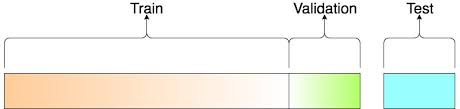

### Example: tune regularization in Lasso

In [2]:
# load data
df_ad = pd.read_csv('../datasets/Advertising.csv')

In [3]:

# Split target and predictors
X = df_ad.drop('Sales', axis=1)
y = df_ad['Sales']


# split data in train/ validation/ test/ 
X_train, X_test, y_train, y_test = train_test_split( X, 
                                                    y, 
                                                    test_size=0.20, 
                                                    random_state=123)

X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=0.20, 
                                                  random_state=123)

In [4]:
# Select the best model with the validation set approach
regularization_space = np.linspace(0, 10, 100)
regularization_space

array([ 0.        ,  0.1010101 ,  0.2020202 ,  0.3030303 ,  0.4040404 ,
        0.50505051,  0.60606061,  0.70707071,  0.80808081,  0.90909091,
        1.01010101,  1.11111111,  1.21212121,  1.31313131,  1.41414141,
        1.51515152,  1.61616162,  1.71717172,  1.81818182,  1.91919192,
        2.02020202,  2.12121212,  2.22222222,  2.32323232,  2.42424242,
        2.52525253,  2.62626263,  2.72727273,  2.82828283,  2.92929293,
        3.03030303,  3.13131313,  3.23232323,  3.33333333,  3.43434343,
        3.53535354,  3.63636364,  3.73737374,  3.83838384,  3.93939394,
        4.04040404,  4.14141414,  4.24242424,  4.34343434,  4.44444444,
        4.54545455,  4.64646465,  4.74747475,  4.84848485,  4.94949495,
        5.05050505,  5.15151515,  5.25252525,  5.35353535,  5.45454545,
        5.55555556,  5.65656566,  5.75757576,  5.85858586,  5.95959596,
        6.06060606,  6.16161616,  6.26262626,  6.36363636,  6.46464646,
        6.56565657,  6.66666667,  6.76767677,  6.86868687,  6.96

In [5]:
validation_score = []
for a in regularization_space:
    lasso = Lasso(alpha=a) 
    lasso.fit(X_train, y_train)
    score = lasso.score(X_val, y_val)
    validation_score.append(score)

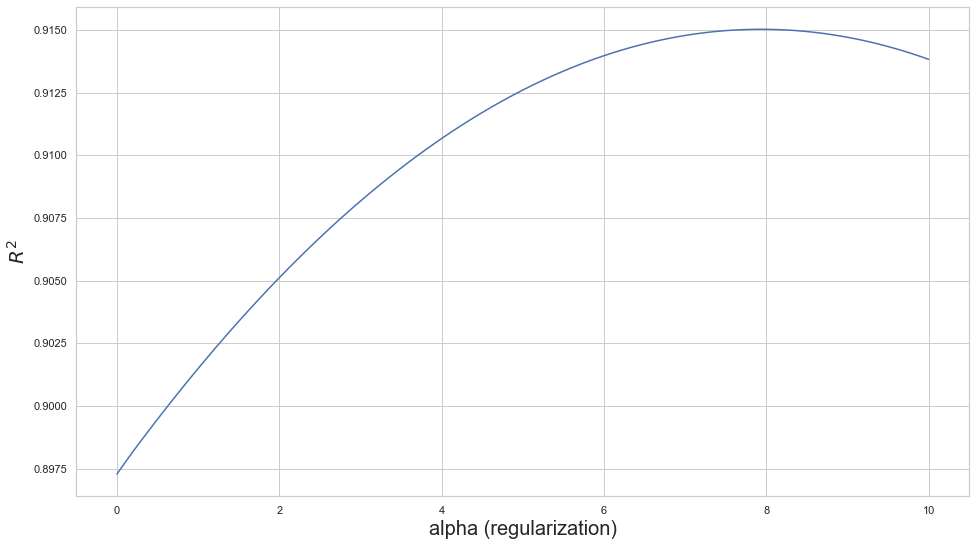

In [6]:
plt.plot(regularization_space, validation_score);
plt.xlabel('alpha (regularization)', size=20)
plt.ylabel(f'$R^2$', size=20)
plt.show()

In [7]:
alpha_val = regularization_space[validation_score.index(max(validation_score))]

In [8]:
# rejoin train and val set 
X_train = pd.concat([X_train, X_val], axis=0)
y_train = pd.concat([y_train, y_val], axis=0)

In [9]:
lasso = Lasso(alpha=alpha_val)
lasso.fit(X_train, y_train)
lasso.score(X_test, y_test)

0.9140719891117921

## k-fold cross validation


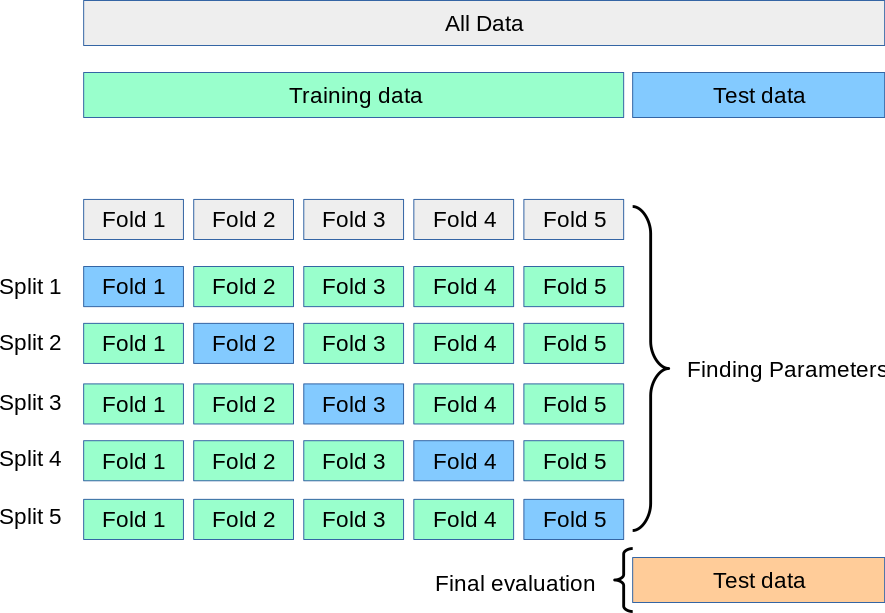

### GridSearch

We explore a space of parameters and evaluate their impact on the performance of the model. Then, we keep the best set of parameters to calculate our error in the Test set.

**Note** This few lines are really enough to train good models!

In [10]:
# load data
df_ad = pd.read_csv('../datasets/Advertising.csv')
# Split target and predictors
X = df_ad.drop('Sales', axis=1)
y = df_ad['Sales']


# split data in train/ test/ 
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.20, 
                                                    random_state=123)

In [11]:
model = Ridge()
parameter_space = {'alpha': np.linspace(0, 100, 1000),}

grid_search = GridSearchCV(model,
                           param_grid=parameter_space,
                           cv=5)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': array([  0.        ,   0.1001001 ,   0.2002002 ,   0.3003003 ,
         0.4004004 ,   0.5005005 ,   0.6006006 ,   0.7007007 ,
         0.8008008 ,   0.9009009 ,   1.001001  ,   1.1011011 ,
         1.2012012 ,   1.3013013 ,   1.4014014 ,   1.5015015 ,
         1.6016016 ,   1.7017017 ,   1.8018018 ,   1.9019019 ,
         2.002002  ,   2.1021021 ,   2.2022022 ,   2.3023023 ,
         2.4024024 ,   2.5025025 ,   2.6026026 ,   2.7027027 ,
         2.8028028 ,   2.9029...
        96.4964965 ,  96.5965966 ,  96.6966967 ,  96.7967968 ,
        96.8968969 ,  96.996997  ,  97.0970971 ,  97.1971972 ,
        97.2972973 ,  97.3973974 ,  97.4974975 ,  97.5975976 ,
        97.6976977 ,  97.7977978 ,  97.8978979 ,  97.997998  ,
        98.0980981 ,  98.1981982 ,  98.2982983 ,  98.3983984 ,
        98.4984985 ,  98.5985986 ,  98.6986987 ,  98.7987988 ,
        98.8988989 ,  98.998999  ,  99.0990991 ,  99.1991992 ,
        99.2992993 ,  99.3993994 ,  99.4994995 ,  99.5995996 ,
        99.6996997 ,  99.7997998 ,  99.8998999 , 100.        ])})

In [12]:
best_model = grid_search.best_estimator_
best_model

Ridge(alpha=0.0)

In [13]:
y_pred = best_model.predict(X_test)

In [14]:
r2_score(y_test, y_pred)

0.9288609285248162

In [15]:
grid_search.best_score_

0.8715311078043417

## KNN Neighbors (classification)



[See Wikipedia article](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm)

[See sklearn implementation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html?highlight=kneig#sklearn.neighbors.KNeighborsClassifier)

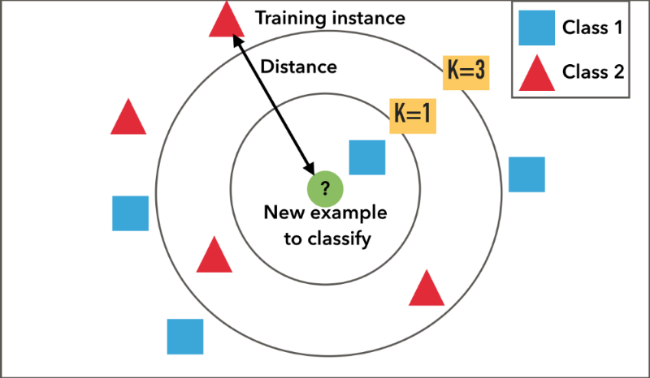

In [64]:
df_cancer = pd.read_csv('../datasets/breast_cancer.csv')

In [65]:
df_cancer

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,...,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension,is_cancer
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,1
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,1
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,1
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,1
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,1
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,1
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,1
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,1


In [28]:
# accuracy (logistic: 0.88)

# Split target and predictors
X = df_cancer.drop('is_cancer', axis=1)
y = df_cancer['is_cancer']


# split data in train/ test/ 
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.20, 
                                                    random_state=123)

In [29]:
n_neighbors = np.arange(1,10)

In [30]:
# [self-guided] Apply a KNN neighborhs classifier with a GridSearchCV
model = KNeighborsClassifier()
parameter_space = {'n_neighbors': n_neighbors,
                   }

grid_search = GridSearchCV(model,
                           param_grid=parameter_space,
                           cv=5)

grid_search.fit(X_train, y_train)
# How does this result compares to the one using LogisticRegression?

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([1, 2, 3, 4, 5, 6, 7, 8, 9])})

In [31]:
grid_search.best_score_

0.9274725274725275

In [33]:
best_knn = grid_search.best_estimator_

In [35]:
best_knn.score(X_test, y_test)

0.9473684210526315

## Standarization of variables

Needed with parameter shrinkage (Lasso and Ridge) and whenever we are using metric distances (such as KNN)

In [38]:
X_train.describe()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,...,worst_radius,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension
count,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,...,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000
mean,14.188086,19.392000,92.402769,659.778462,0.096688,0.106124,0.090644,0.050018,0.181922,0.062987,...,16.349314,25.734901,107.830308,888.612967,0.132350,0.255226,0.274146,0.116275,0.290182,0.083903
std,3.519728,4.455268,24.220321,347.214043,0.014141,0.053248,0.079951,0.038939,0.028487,0.007329,...,4.868860,6.325063,33.795670,573.630619,0.023061,0.153465,0.206880,0.066025,0.062815,0.017372
min,6.981000,10.380000,43.790000,143.500000,0.052630,0.026500,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.490000,50.410000,185.200000,0.084090,0.043270,0.000000,0.000000,0.156500,0.055040
25%,11.650000,16.050000,74.720000,415.650000,0.086650,0.066735,0.030410,0.020940,0.161950,0.057685,...,12.980000,21.070000,84.035000,513.500000,0.116700,0.148600,0.118350,0.065280,0.249400,0.071180
50%,13.490000,18.950000,87.210000,561.000000,0.096460,0.095090,0.064760,0.034000,0.179300,0.061680,...,15.050000,25.270000,98.840000,698.800000,0.131100,0.217000,0.228200,0.100100,0.282300,0.080090
75%,16.135000,21.925000,106.450000,801.550000,0.105400,0.130950,0.134000,0.074950,0.196300,0.066395,...,19.125000,30.200000,127.000000,1111.500000,0.146450,0.338100,0.387200,0.162650,0.316550,0.092120
max,27.420000,39.280000,186.900000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,0.937900,1.252000,0.291000,0.663800,0.173000


In [39]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [43]:
pd.DataFrame(X_train, columns=X.columns).describe()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,...,worst_radius,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension
count,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,...,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02
mean,5.075305e-17,-6.963904e-16,3.084224e-16,2.830459e-16,1.483551e-16,-3.513673e-17,6.441734e-17,-6.051325e-17,5.075305e-16,-5.270509e-17,...,3.904081e-18,1.683635e-16,-1.913000e-16,-1.171224e-17,1.795877e-16,1.171224e-17,-1.424990e-16,6.441734e-17,3.084224e-16,-2.147245e-16
std,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,...,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00
min,-2.049880e+00,-2.025000e+00,-2.009316e+00,-1.488554e+00,-3.119031e+00,-1.497005e+00,-1.134988e+00,-1.285946e+00,-2.668076e+00,-1.779435e+00,...,-1.731120e+00,-2.096340e+00,-1.700913e+00,-1.227597e+00,-2.095018e+00,-1.382656e+00,-1.326603e+00,-1.763005e+00,-2.130541e+00,-1.663355e+00
25%,-7.218965e-01,-7.509489e-01,-7.308835e-01,-7.038805e-01,-7.106540e-01,-7.405516e-01,-7.542132e-01,-7.475845e-01,-7.018677e-01,-7.242377e-01,...,-6.927747e-01,-7.383382e-01,-7.048684e-01,-6.546475e-01,-6.793830e-01,-6.955558e-01,-7.539024e-01,-7.732045e-01,-6.499603e-01,-7.332266e-01
50%,-1.985534e-01,-9.931760e-02,-2.146332e-01,-2.848018e-01,-1.617503e-02,-2.074523e-01,-3.241046e-01,-4.118152e-01,-9.214990e-02,-1.785403e-01,...,-2.671559e-01,-7.358232e-02,-2.663123e-01,-3.312618e-01,-5.426382e-02,-2.493611e-01,-2.223335e-01,-2.452501e-01,-1.256214e-01,-2.197543e-01
75%,5.537523e-01,5.691662e-01,5.806155e-01,4.087611e-01,6.167141e-01,4.667476e-01,5.428739e-01,6.409988e-01,5.052682e-01,4.655056e-01,...,5.707170e-01,7.067145e-01,5.678477e-01,3.889827e-01,6.120959e-01,5.406123e-01,5.470745e-01,7.031573e-01,4.202330e-01,4.735197e-01
max,3.763495e+00,4.468843e+00,3.905863e+00,5.308680e+00,4.722706e+00,4.498599e+00,4.209126e+00,3.886854e+00,4.290087e+00,4.706100e+00,...,4.048660e+00,3.767757e+00,4.246920e+00,5.873277e+00,3.917848e+00,4.453296e+00,4.731879e+00,2.649250e+00,5.954479e+00,5.134534e+00


In [44]:
model = KNeighborsClassifier()
n_neighbors = np.arange(1,20)
parameter_space = {'n_neighbors': n_neighbors,
                   }

grid_search = GridSearchCV(model,
                           param_grid=parameter_space,
                           cv=5)

grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])})

In [45]:
grid_search.best_score_

0.9582417582417582

In [46]:
best_knn = grid_search.best_estimator_
best_knn

KNeighborsClassifier(n_neighbors=7)

In [47]:
X_test = scaler.transform(X_test)
best_knn.score(X_test, y_test)

0.9824561403508771

## Extra: sklearn pipelines

Encapsulate all parts of the modeling process into a single object. 

In [55]:
final_model = make_pipeline(StandardScaler(),
                            KNeighborsClassifier())

n_neighbors = np.arange(1,20)
parameter_space = {'kneighborsclassifier__n_neighbors': n_neighbors,
                   }

grid_search = GridSearchCV(final_model,
                           param_grid=parameter_space,
                           cv=5)

grid_search.fit(X_train, y_train)



GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             param_grid={'kneighborsclassifier__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])})

In [57]:
knn_best = grid_search.best_estimator_
knn_best

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=7))])

In [58]:
knn_best.score(X_test, y_test)

0.9824561403508771

In [59]:
knn_best.fit(X, y) # to production!!

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=7))])

In [75]:
knn_best.predict_proba(X)

array([[0.        , 1.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       ...,
       [0.28571429, 0.71428571],
       [0.        , 1.        ],
       [1.        , 0.        ]])

## References
* [Introduction to Statistical Learning ISL (Chapter 2)](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf)
* [repo from tdpetrou with materials from ISL](https://github.com/tdpetrou/Machine-Learning-Books-With-Python/tree/master/Introduction%20to%20Statistical%20Learning)
